In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Импорт данных и предобработка

In [2]:
df = pd.read_table('car.data', sep= ',', names= ['buying_price','maint_price','doors','persons','lug_boot','safety','acceptability'])
df.head()

,buying_price,maint_price,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


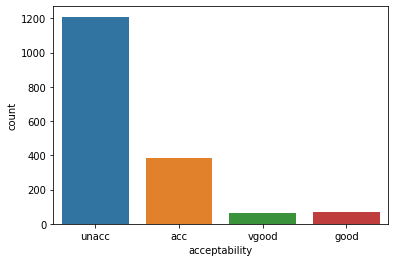

In [3]:
sns.countplot(x='acceptability',data=df)

In [4]:
df.describe()

,buying_price,maint_price,doors,persons,lug_boot,safety,acceptability
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,low,low,5more,4,big,low,unacc
freq,432,432,432,576,576,576,1210


Как мы видим - все фичи категориальные. Перекодируем.

In [5]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

d = defaultdict(LabelEncoder)
X = np.c_[
    df[df.drop('acceptability',axis=1).columns].apply(lambda x: d[x.name].fit_transform(x)).values,
]
y = df[['acceptability']].values

# Голосуем за модели

Бьём выборку на train/test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=df['acceptability'],
    random_state=42)

Объявляем 3 базовых классификатора + голосующий

In [7]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

Пара доп.функций: для оценки моделей и для отрисовки confusion matrix

In [8]:
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

def quality_report(prediction, actual):    
    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual, average= 'weighted')
    recall = recall_score(prediction, actual, average= 'weighted')
    f1 = f1_score(prediction, actual, average= 'weighted')
    
    quality_list = [acc.round(5), precision.round(5), recall.round(5), f1.round(5)]
    
    return quality_list

In [9]:
from sklearn.metrics import confusion_matrix

def plot_confusion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data = cm, index= np.unique(y), columns= np.unique(y))
    plt.figure(figsize = (5,5))
    plt.title(clf.__class__.__name__, fontsize=14)
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap="YlGnBu",
        cbar=False);

Обучаем модели, сравниваем результат

,Accuracy,Precision,Recall,F1
LogisticRegression,0.68015,0.84653,0.68015,0.74963
RandomForestClassifier,0.96532,0.96518,0.96532,0.96521
SVC,0.89981,0.91866,0.89981,0.90659
VotingClassifier,0.91908,0.93709,0.91908,0.92558


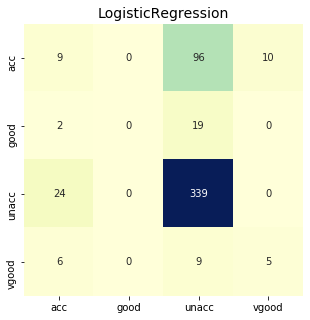

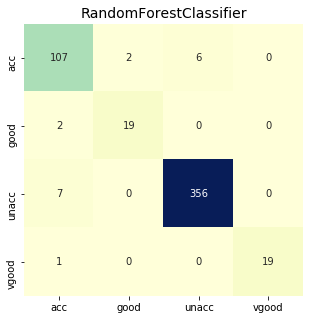

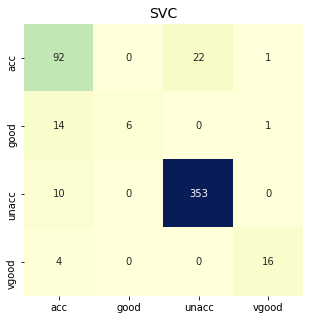

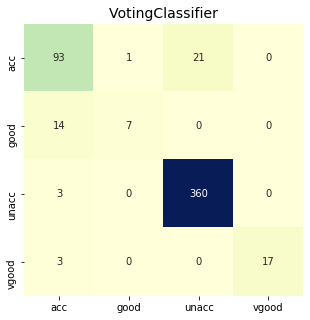

In [10]:
quality_df = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1"])
    
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    plot_confusion(y_test, y_pred)
    quality_df.loc[clf.__class__.__name__, :] = quality_report(y_pred, y_test)
    
quality_df

Видим, что RF сам по себе даёт хорошие метрики, даже лучше, чем Voting. Посмотрим на важность признаков, которые раздала модель

In [11]:
for name, score in zip(df.columns, rnd_clf.feature_importances_):
    print(name, score)

buying_price 0.18356944945191933
maint_price 0.15863803921163647
doors 0.06725032501568191
persons 0.2235086868099097
lug_boot 0.09018305387137258
safety 0.27685044563947997


# Подбор параметров

Теперь попробуем поподбирать параметры для RF, как лучшего предсказателя - может получится вытянуть ещё больше точности

In [12]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': range(40, 50), 'bootstrap': [True, False], 'warm_start': [True, False]}
grid = GridSearchCV(estimator=rnd_clf, param_grid=params, cv=5, scoring= 'accuracy')
grid = grid.fit(X_train, y_train)
print("Лучшие параметры: {} \n Точность: {}".format(grid.best_estimator_, grid.best_score_))

Лучшие параметры: RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=41,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=True) 
 Точность: 0.9636055004972395


Странно, но точность вышла хуже, чем с параметрами по умолчанию